# Features: elevation features

In this notebook, we extract the elevation at each station location from the swissALTI3D dataset.

In [ ]:
import contextily as cx
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rio
from tqdm import tqdm

from uhi_drivers_lausanne import stac_utils

tqdm.pandas()

In [ ]:
stations_gdf_filepath = "../data/interim/stations-gdf.gpkg"
alti3d_datetime = "2019/2019"
dst_filepath = "../data/interim/elev-features.csv"

In [ ]:
stations_gdf = gpd.read_file(stations_gdf_filepath).to_crs(stac_utils.CLIENT_CRS)
station_index_name = stations_gdf.columns.drop("geometry")[0]
stations_gdf = stations_gdf.set_index(station_index_name)

In [ ]:
client = stac_utils.SwissTopoClient()

alti3d_gdf = client.gdf_from_collection(
    stac_utils.SWISSALTI3D_COLLECTION,
    extent_geom=stations_gdf.unary_union.convex_hull,
    datetime=alti3d_datetime,
    extension=".tif",
)

In [ ]:
def get_elev(gdf):
    with rio.open(gdf[stac_utils.SWISSALTI3D_COLLECTION].iloc[0]) as src:
        elev_df = pd.DataFrame(
            np.array(
                [
                    val
                    for val in src.sample(
                        gdf["geometry"].to_crs(src.crs).apply(lambda p: (p.x, p.y))
                    )
                ],
                dtype=np.float32,
            ).flatten(),
            columns=["elevation"],
            index=gdf.index,
        )
        return elev_df[elev_df["elevation"] != src.nodata]


# we want to minimize the download and opening of remote files so we perform an sjoin of
# the tile extent and stations to get, for each tile, the list of stations located
# within the tile extent
elev_ser = (
    alti3d_gdf.sjoin(stations_gdf, predicate="contains", how="right")
    .groupby(by=stac_utils.SWISSALTI3D_COLLECTION)
    .progress_apply(get_elev)
    .reset_index(level=0)["elevation"]
)

100%|█████████████████████████████████████████████████| 91/91 [03:09<00:00,  2.08s/it]


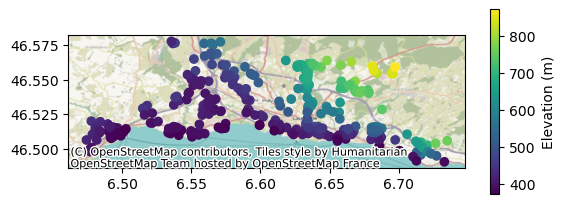

In [ ]:
ax = stations_gdf.assign(elevation=elev_ser).plot(
    "elevation", legend=True, legend_kwds={"label": "Elevation (m)", "shrink": 0.5}
)
cx.add_basemap(ax, crs=stations_gdf.crs)

In [ ]:
# dump to csv
elev_ser.to_csv(dst_filepath)